In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.datasets import make_moons

## Data preprocessing

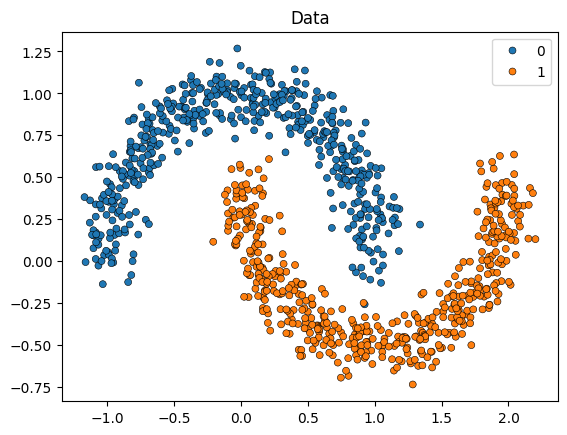

In [2]:
points, labels = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=0)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=labels, marker="o", s=25, edgecolor="k", legend=True
).set_title("Data")
plt.show()

In [3]:
X = torch.from_numpy(points).to(dtype=torch.float32)
y = torch.from_numpy(labels).to(dtype=torch.float32)

## Setting up the device for training

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## 1. Creating MLP class

In [5]:
class MLP(nn.Module):
    """
    Implements multilayer perceptron (MLP)
    """
    def __init__(self, input_dim, layers_dim=[3, 5, 1], activations=[nn.ReLU(), nn.ReLU()]):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.layers = nn.Sequential()

        layers_dim.insert(0, input_dim)
        n_layers = len(layers_dim)
        
        torch.manual_seed(2)
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(layers_dim[i-1], layers_dim[i]))
            if i <= len(activations):
                self.layers.append(activations[i-1])

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.layers(x)
        return logits

## 2. Creating CustomDataset class

In [6]:
class CustomDataset(Dataset):
    def __init__(self, features, target, file_path=''):
        if file_path:
            self.dataset = pd.read_csv(file_path)
            self.target = self.dataset[target].to_numpy()
            self.features = self.dataset[features].to_numpy()
        else:
            self.dataset = None
            self.target = np.array(target).flatten()
            self.features = np.array(features)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        target = self.target[index]
        features = self.features[index]
        return features, target

## 3. Training loop

#### Configuring MLP model

In [19]:
model = MLP(input_dim=X.shape[1], layers_dim=[5, 10, 1], activations=[nn.ReLU(), nn.ReLU()]).to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


#### Configuring loss function and optimizer

In [20]:
loss_function = nn.BCELoss()
# loss_function = nn.CrossEntropyLoss()

learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Training our model

In [21]:
dataset = CustomDataset(points, labels)

In [22]:
train_dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [23]:
len(train_dataloader)

10

Epoch 1: loss=0.6663187146186829
Epoch 2: loss=0.634044224023819
Epoch 3: loss=0.5916985392570495
Epoch 4: loss=0.5385299682617187
Epoch 5: loss=0.4805980145931244
Epoch 6: loss=0.4298875153064728
Epoch 7: loss=0.39041360914707185
Epoch 8: loss=0.35748795568943026
Epoch 9: loss=0.3301635980606079
Epoch 10: loss=0.3078172892332077
Epoch 11: loss=0.28686012923717497
Epoch 12: loss=0.2714019402861595
Epoch 13: loss=0.26097360998392105
Epoch 14: loss=0.2530242621898651
Epoch 15: loss=0.24634023159742355
Epoch 16: loss=0.2416841983795166
Epoch 17: loss=0.23691809624433519
Epoch 18: loss=0.23184886276721955
Epoch 19: loss=0.22807682156562806
Epoch 20: loss=0.2231742963194847
Epoch 21: loss=0.21849629878997803
Epoch 22: loss=0.21360754817724228
Epoch 23: loss=0.20797696709632874
Epoch 24: loss=0.2024909660220146
Epoch 25: loss=0.19545641243457795
Epoch 26: loss=0.18886981084942817
Epoch 27: loss=0.18298782110214235
Epoch 28: loss=0.17441080808639525
Epoch 29: loss=0.16617205291986464
Epoch 30

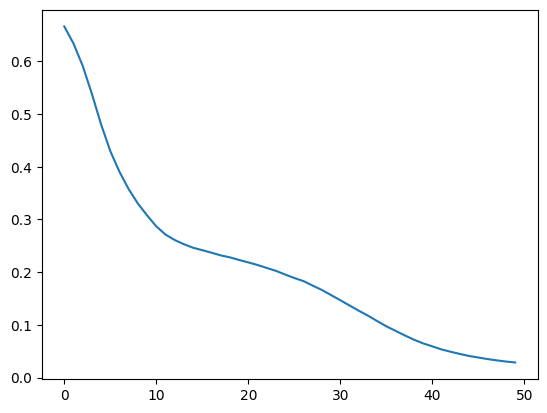

In [24]:
n_epochs = 50
epoch_loss = []

for epoch in range(n_epochs):
    accumulated_loss = 0.0  # accumulated loss above all batches
    
    for i, data in enumerate(train_dataloader, 0):
        Xb, yb = data
        Xb, yb = Xb.float(), yb.float()
        # yb = yb.reshape((yb.shape[0], 1))
        
        # print(f'inputs:\n {inputs}\n')
        # print(f'targets:\n {targets.shape}\n')
    
        optimizer.zero_grad()
        
        y_pred = model(Xb).sigmoid().flatten()
        # y_pred = model(X).flatten()
        L = loss_function(y_pred, yb)
        
        accumulated_loss += L.item()
        
        L.backward()
    
        optimizer.step()

    # Saving mean loss above all batches
    epoch_loss.append(accumulated_loss / len(train_dataloader))
    print(f'Epoch {epoch+1}: loss={epoch_loss[epoch]}')

plt.plot(epoch_loss)
plt.show()

#### Model evaluation on the entire dataset

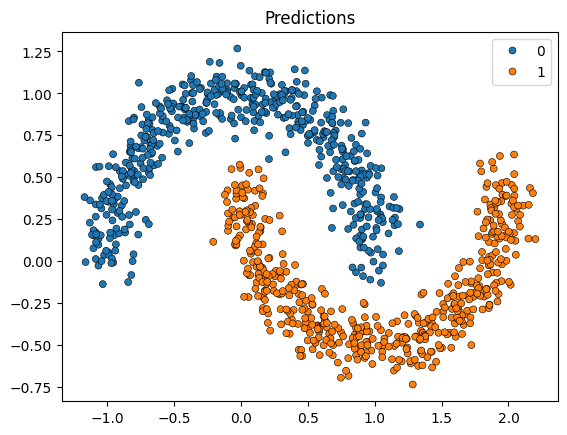

In [25]:
predictions = model(X).sigmoid().detach().numpy().flatten()
predictions = (predictions > 0.5).astype(int)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=predictions, marker="o", s=25, edgecolor="k", legend=True
).set_title("Predictions")
plt.show()

## Same code, but without batches

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)
Epoch 1: loss=0.6812855005264282
Epoch 2: loss=0.673526406288147
Epoch 3: loss=0.6664008498191833
Epoch 4: loss=0.6604772806167603
Epoch 5: loss=0.6546918153762817
Epoch 6: loss=0.6487134695053101
Epoch 7: loss=0.6424977779388428
Epoch 8: loss=0.6359961628913879
Epoch 9: loss=0.6291224956512451
Epoch 10: loss=0.6217783689498901
Epoch 11: loss=0.6139289736747742
Epoch 12: loss=0.6055304408073425
Epoch 13: loss=0.5965890884399414
Epoch 14: loss=0.5871217250823975
Epoch 15: loss=0.5771393775939941
Epoch 16: loss=0.5666775107383728
Epoch 17: loss=0.5558565855026245
Epoch 18: loss=0.5447656512260437
Epoch 19: loss=0.5334608554840088
Epoch 20: loss=0.5220057368278503
Epoch 21: loss=0.5104830861091614
Epoch 22: loss=0.498992383480072
Epoch 23: loss=0.487

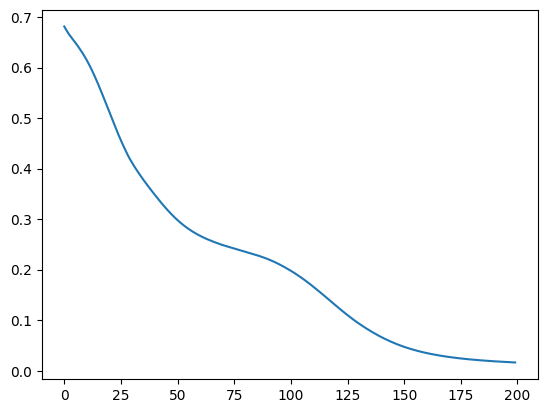

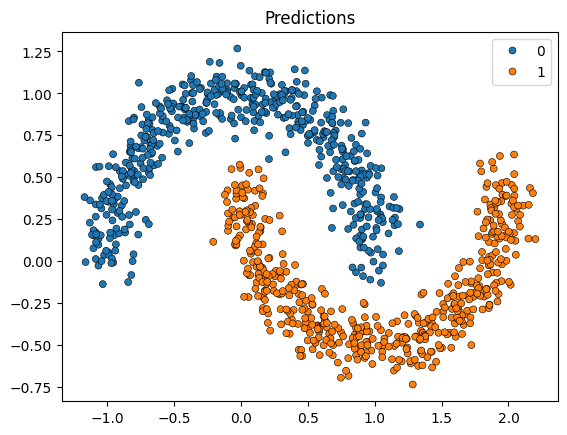

In [26]:
model = MLP(input_dim=X.shape[1], layers_dim=[5, 10, 1], activations=[nn.ReLU(), nn.ReLU()]).to(device)
print(model)
loss_function = nn.BCELoss()
# loss_function = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epochs = 200
loss = []

for i in range(n_epochs):
    optimizer.zero_grad()
    
    y_pred = model(X).sigmoid().flatten()
    L = loss_function(y_pred, y)
    
    loss.append(L.item())
    print(f'Epoch {i+1}: loss={L.item()}')
    
    L.backward()

    optimizer.step()

plt.plot(loss)
plt.show()

predictions = model(X).sigmoid().detach().numpy().flatten()
predictions = (predictions > 0.5).astype(int)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=predictions, marker="o", s=25, edgecolor="k", legend=True
).set_title("Predictions")
plt.show()

#### Testing CrossEntropyLoss instead of BCELoss

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)
Epoch 1: loss=3439.91455078125
Epoch 2: loss=3433.3447265625
Epoch 3: loss=3427.298095703125
Epoch 4: loss=3422.193359375
Epoch 5: loss=3417.07470703125
Epoch 6: loss=3411.61669921875
Epoch 7: loss=3405.795654296875
Epoch 8: loss=3399.623046875
Epoch 9: loss=3393.0869140625
Epoch 10: loss=3386.1767578125
Epoch 11: loss=3378.906982421875
Epoch 12: loss=3371.300537109375
Epoch 13: loss=3363.41845703125
Epoch 14: loss=3355.318603515625
Epoch 15: loss=3347.09716796875
Epoch 16: loss=3338.845703125
Epoch 17: loss=3330.727783203125
Epoch 18: loss=3322.909423828125
Epoch 19: loss=3315.55810546875
Epoch 20: loss=3308.87890625
Epoch 21: loss=3303.083984375
Epoch 22: loss=3298.325927734375
Epoch 23: loss=3294.714111328125
Epoch 24: loss=3292.2470703125
Epoc

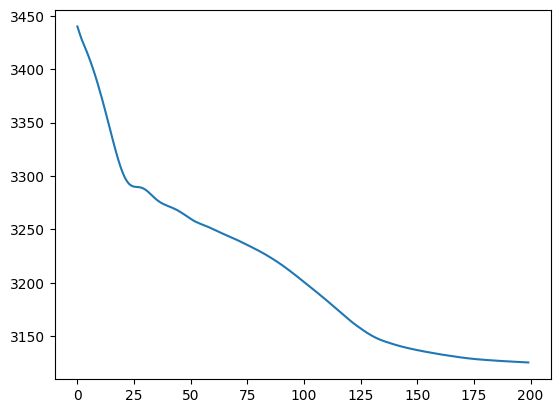

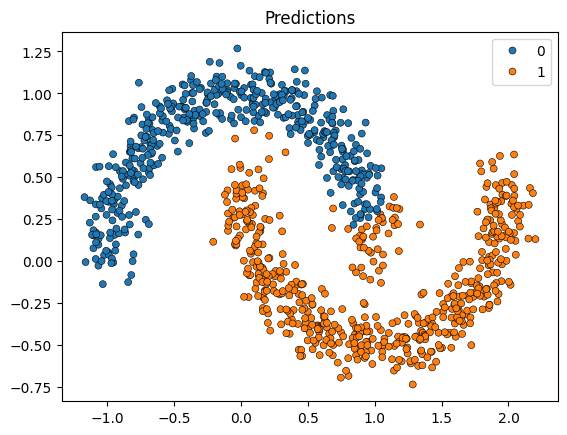

In [14]:
model = MLP(input_dim=X.shape[1], layers_dim=[5, 10, 1], activations=[nn.ReLU(), nn.ReLU()]).to(device)
print(model)
# loss_function = nn.BCELoss()
loss_function = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epochs = 200
loss = []

for i in range(n_epochs):
    optimizer.zero_grad()
    
    # y_pred = model(X).sigmoid().flatten()
    y_pred = model(X).flatten()
    # y_pred = model(X).softmax(dim=1).flatten()
    L = loss_function(y_pred, y)
    
    loss.append(L.item())
    print(f'Epoch {i+1}: loss={L.item()}')
    
    L.backward()

    optimizer.step()

plt.plot(loss)
plt.show()

predictions = y_pred.detach().numpy() 
predictions = (predictions > 0.5).astype(int)

sns.scatterplot(
    x=points[:, 0], y=points[:, 1], hue=predictions, marker="o", s=25, edgecolor="k", legend=True
).set_title("Predictions")
plt.show()